In [97]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import skimage.transform as tf
%matplotlib inline

In [98]:
def load_dataset():
    train_dataset = h5py.File("datasets/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    
    test_dataset = h5py.File("datasets/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    
    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig  = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return  train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
    

In [99]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [100]:
train_set_x_orig[30][0][0]
train_set_x_orig[30][0][:2]
len(train_set_x_orig[0][0])

64

In [101]:
len(train_set_x_orig[0][0][0])

3

In [102]:
classes[0]
len(classes)

2

标签为[1], 这是一个'cat' 图片.


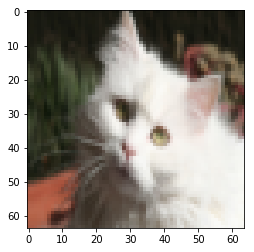

In [103]:
index = 102
plt.imshow(train_set_x_orig[index])
print ("Label" + str(train_set_y[:, index]) + ", this is a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' 图片.")

In [104]:
print("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [105]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1] 

print ("Training sample: m_train = " + str(m_train))
print ("test sample: m_test = " + str(m_test))
print ("pic dim: num_px = " + str(num_px))

训练样本数: m_train = 209
测试样本数: m_test = 50
每张图片的宽/高: num_px = 64


In [106]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


In [107]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255.

In [108]:
train_set_x[0]
len(train_set_x[0])

209

In [109]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [110]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    #print(w.T)
    return w, b 

In [111]:
initialize_with_zeros(10)

(array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]), 0)

In [145]:
def propagate(w, b, X, Y):
    m = X.shape[1]  # of samples X shape: (12288 * 209)
    # w shape: (12288 * 1)
    # w.T shape: (1 * 12288)
    
    # forward broadcasting
    A = sigmoid(np.dot(w.T, X) + b) # 1 * 12288 X 12288 * 209
    cost = -np.sum(Y*np.log(A) + (1 - Y)*np.log(1- A)) / m
    
    # backward broadcasting

    dZ = A - Y # Y shape: (1, 209)
    dw = np.dot(X,dZ.T)/m # 12288* 209 X 209 * 1 
    db = np.sum(dZ) / m 
    
    #store dw and db into dictionary
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [148]:
def optimize(w,  b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    parameters:
    w -- weight, dimension is (12288, 1)
    b -- bias
    X -- feature of picture, dimension is (12288, 209)
    Y -- label of picture, 0 represents cat, 1 represents no cat, dimension is (1, 209)
    num_interation -- time of optimization
    learning_rate -- use to control optimization
    print_cost -- if it is set to True, then cost will be print out
    
    return:
    params -- optimized w and b
    costs -- print out costs every 100 optimization, the lower the cost, the better the optimization
    """
    
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b , X, Y) #calculate the gradient and cost

        # get the gradient from the dictionary
        dw = grads["dw"]
        db = grads["db"]
        
        # perform gradient descent, update parameters and lower the costs
        w = w - learning_rate * dw
        b = b - learning_rate * db
        # w shape: (12288  * 1)
        # b : single num 
        
        # store costs
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("The cost after %i optimization is: %f" % (i, cost))
                
    params = {"w": w, "b": b}
    return params, costs

In [129]:
def predict(w, b, X):
    '''
    parameters:
    w -- weight, dimension is (12288, 1)
    b -- bias
    X -- feature of picture, dimension is (12288, number of pictures)
    
    return:
    Y_prediction -- the predicted result for each picture
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))  # shape: (1 * 209)

    A = sigmoid(np.dot(w.T, X) + b) # predict the pic thru this line of code
    # A shape: (1 * 209)
    
    # the predict results from above will be decimal number. We will transfer them into format of 0 and 1
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
            
    return Y_prediction

In [146]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    parameters:
    X_train -- train pics, dimension is (12288, 209)
    Y_train -- train label, dimension is (1, 209)
    X_test -- test pics, dimension is (12288, 50)
    Y_test -- test label, dimension is (1, 50)
    num_interation -- time of optimization
    learning_rate -- use to control optimization
    print_cost -- if it is set o True, then cost will be print out
    
    return:
    d - info
    """
    
    # init param
    w, b = initialize_with_zeros(X_train.shape[0]);# shape: (12288,209)
    
    # optimze param by using train data
    parameters, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # get w and b
    w = parameters["w"]
    b = parameters["b"]
    
    # predict pic using trained w and b
    Y_prediction_train = predict(w, b, X_train) 
    Y_prediction_test = predict(w, b, X_test)
    
    # print out prediction accuracy
    print("Accuracy of train data: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Accuracy of test data: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
     "Y_prediction_test": Y_prediction_test, 
     "Y_prediction_train" : Y_prediction_train, 
     "w" : w, 
     "b" : b,
     "learning_rate" : learning_rate,
     "num_iterations": num_iterations}
    
    return d

In [152]:
# start to load data and predict
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

The cost after 0 optimization is: 0.693147
The cost after 100 optimization is: 0.584508
The cost after 200 optimization is: 0.466949
The cost after 300 optimization is: 0.376007
The cost after 400 optimization is: 0.331463
The cost after 500 optimization is: 0.303273
The cost after 600 optimization is: 0.279880
The cost after 700 optimization is: 0.260042
The cost after 800 optimization is: 0.242941
The cost after 900 optimization is: 0.228004
The cost after 1000 optimization is: 0.214820
The cost after 1100 optimization is: 0.203078
The cost after 1200 optimization is: 0.192544
The cost after 1300 optimization is: 0.183033
The cost after 1400 optimization is: 0.174399
The cost after 1500 optimization is: 0.166521
The cost after 1600 optimization is: 0.159305
The cost after 1700 optimization is: 0.152667
The cost after 1800 optimization is: 0.146542
The cost after 1900 optimization is: 0.140872
Accuracy of train data: 99.04306220095694%
Accuracy of test data: 70.0%


Label is 1, prediction results is 1


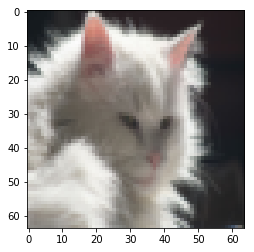

In [153]:
# check the results of prediction
index = 8
plt.imshow(test_set_x[:, index].reshape(num_px, num_px,3))
print ("Label is " + str(test_set_y[0,index]) + ", prediction results is " + str(int(d["Y_prediction_test"][0,index])))

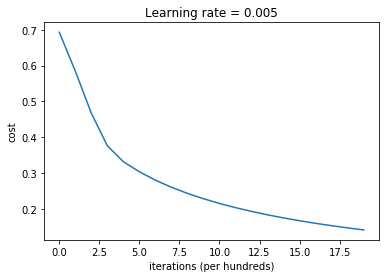

In [154]:
# print out how the costs change along with increasing number of train
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

learning rate: 0.01
Accuracy of train data: 99.52153110047847%
Accuracy of test data: 68.0%

-------------------------------------------------------

learning rate: 0.001
Accuracy of train data: 88.99521531100478%
Accuracy of test data: 64.0%

-------------------------------------------------------

learning rate: 0.0001
Accuracy of train data: 68.42105263157895%
Accuracy of test data: 36.0%

-------------------------------------------------------



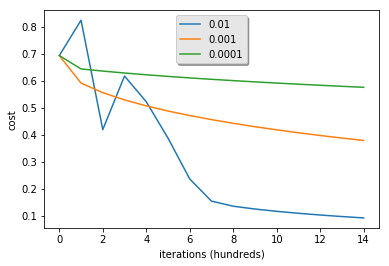

In [155]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print("learning rate: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')
    
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()    

Predict result 1


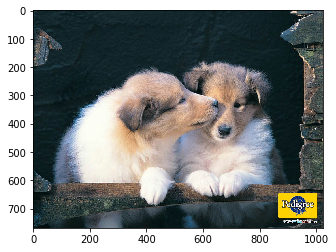

In [157]:
my_image = "another_dog.jpg" 
fname = "images/" + my_image

image = np.array(plt.imread(fname))
my_image = tf.resize(image,(num_px,num_px), mode='reflect').reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("Predict result " + str(int(np.squeeze(my_predicted_image))))